# Part I - A restaurants exploration through text mining and NLP

## 1. Web Scraping
- **First goal**: collection of reviews data from several restaurants from https://www.tripadvisor.fr
- Here we collected 20,000+ reviews data for different types of cuisine such as german, chinese, vietnamese, african, french, italian.

In [ ]:
import requests
import re
import random
import time
import numpy as np
import platform
from bs4 import BeautifulSoup

class SearchEngine:
    def __init__(self):
        self.base_url = "https://www.tripadvisor.fr"
        self.session = None
        self.cookies_list = [
            {"TADCID": "sample1", "TASameSite": "1", "datadome": "dummy-cookie1"},
            {"TADCID": "sample2", "TASameSite": "1", "datadome": "dummy-cookie2"},
        ]
        self.cookies = None
        self.rank = 0
        self.soup = None

    def get_session(self):
        if not self.session:
            print("🔄 Creating new session")
            self.session = requests.Session()
            self.cookies = random.choice(self.cookies_list)
            for name, value in self.cookies.items():
                self.session.cookies.set(name, value, domain=".tripadvisor.fr")
        else:
            print("⚠️ Session already exists")

    def run(self, url, reviews=False):
        self.get_session()
        self.url = url

        user_agents = [
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 Chrome/122 Safari/537.36",
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 Safari/605.1.15",
            "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 Chrome/121 Safari/537.36",
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:120.0) Gecko/20100101 Firefox/120.0"
        ]
        user_agent = random.choice(user_agents)

        headers = {
            "User-Agent": user_agent,
            "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
            "Accept-Language": "fr-FR,fr;q=0.9,en-US;q=0.8",
            "Connection": "keep-alive",
            "DNT": "1",
            "Upgrade-Insecure-Requests": "1",
            "Referer": "https://www.tripadvisor.fr/",
        }

        self.session.headers.update(headers)
        time.sleep(random.uniform(2, 5))

        try:
            response = self.session.get(url, headers=headers, timeout=(6, 30))
        except Exception as e:
            print(f"❌ Request failed: {e}")
            return None

        if response.status_code == 200:
            self.soup = BeautifulSoup(response.content, "html.parser")
            return
        elif response.status_code == 403:
            print(f"🚫 403 Forbidden at {url}")
            return None
        elif response.status_code == 429:
            print("⏳ 429 Too Many Requests — sleeping")
            time.sleep(random.uniform(60, 90))
            return self.run(url, reviews=reviews)
        else:
            print(f"❌ HTTP {response.status_code} at {url}")
            return None

    def get_next_url(self):
        if not self.soup:
            return None
        pagination = self.soup.find_all("div", class_="mkNRT j")
        if not pagination:
            return None
        attrs = [{"aria-label": "Page suivante"}, {"aria-label": "Next page"}]
        for attr in attrs:
            link = self.soup.find("a", attrs=attr)
            if link:
                return link.get("href")
        return None

class restaurant_info_extractor(SearchEngine):
    def __init__(self):
        super().__init__()
        self.restaurant_info = {}
        self.reviews = []

    def scrape_reviews(self, url):
        self.reviews = [] ####
        self.session = None
        self.run(url, reviews=True)

        if not self.soup:
            print(f"❌ Failed to fetch {url}")
            return {}, [] ####

        seen_reviews = set() ####

        self.extract_reviews(self.soup, seen_reviews)#####
        next_page_href = self.get_next_url()
        page_count = 1
        retry_count = 0
        max_retries = 3 ###

        while next_page_href:
            page_count += 1
            print(f"➡️ Moving to page {page_count}")

            if page_count % 2 == 0:
                self.session = None
                self.get_session()

            time.sleep(random.uniform(2, 5))
            self.run(self.base_url + next_page_href)
            if not self.soup or "403 Forbidden" in str(self.soup):
                retry_count += 1
                if retry_count > 3:
                    print("❌ Too many retries. Stopping pagination.")
                    break
                print("🔁 Retrying session...")
                self.session = None
                self.get_session()
                time.sleep(random.uniform(3, 6))
                continue
            else:
                retry_count = 0
                self.extract_reviews(self.soup)
                print(f"✔️ Total reviews collected so far: {len(self.reviews)}")
                next_page_href = self.get_next_url()

        return self.restaurant_info, self.reviews

    def extract_reviews(self, soup, seen_reviews=None):
        reviews = soup.find_all("div", class_="_c")
        for review in reviews:
            try:
              user_tag = review.find("a", class_="BMQDV _F Gv wSSLS SwZTJ FGwzt ukgoS")
              user = user_tag.text.strip() if user_tag else None
              user_profile = user_tag['href'].replace('/Profile/', '') if user_tag and 'href' in user_tag.attrs else None
              title = review.find("div", class_="biGQs _P fiohW qWPrE ncFvv fOtGX")
              title = title.text.strip() if title else None
              content = review.find("span", class_="JguWG")
              content = content.text.strip() if content else None
              date_review = review.find("div", class_="biGQs _P pZUbB ncFvv osNWb")
              date_review = date_review.text.replace("Rédigé le", "").strip() if date_review else None
              # Type of visit
              type_visit = review.find("span", class_="DlAxN")
              type_visit = type_visit.text.strip() if type_visit else None
              # Number of user contributions
              contrib_tag = review.find("div", class_="vYLts")
              num_contributions_tag = contrib_tag.find("span", class_="b") if contrib_tag else None
              num_contributions = int(num_contributions_tag.text.strip()) if num_contributions_tag else None


              # Extract rating
              rating_tag = review.find("div", class_="OSBmi J k")
              rating_title = rating_tag.find("title").text if rating_tag and rating_tag.find("title") else ""
              match = re.search(r"\d,\d", rating_title)
              rating = float(match.group().replace(",", ".")) if match else None

              # Deduplication check
              dedup_key = f"{user_profile}_{title}"
              if seen_reviews is not None and dedup_key in seen_reviews:
                  continue
              if seen_reviews is not None:
                  seen_reviews.add(dedup_key)

              # ➕ Append review with restaurant_name
              self.reviews.append({
                  "restaurant_name":self.url,
                  "user": user,
                  "user_profile": user_profile,
                  "title": title,
                  "review": content,
                  "rating": rating,
                  "date_review": date_review,
                  "type_visit": type_visit,
                  "num_contributions": num_contributions
                  })
            except AttributeError:
              continue

# Organized by cuisine
if __name__ == "__main__":
    urls = [
        # Indian

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8596850-Reviews-Vedis-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1875899-Reviews-Haveli-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1963405-Reviews-Naveena_Path-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8596850-Reviews-Vedis-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d715489-Reviews-Indisches_Restaurant_Maharadscha-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d4366854-Reviews-AMRIT_Potsdamer_Platz-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d13330159-Reviews-Indian_Village-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10631646-Reviews-Lotus-Berlin.html"

        # African

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1066007-Reviews-Langano-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1037265-Reviews-Bejte_Ethiopian_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d13116641-Reviews-Restaurant_Amitie-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1010493-Reviews-Blue_Nile_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d15115969-Reviews-Addis_Abeba_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d941956-Reviews-Nil_Sudanesischer_Imbiss-Berlin.html",
        # "hhttps://www.tripadvisor.fr/Restaurant_Review-g187323-d10762757-Reviews-Ebe_Ano-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1341043-Reviews-Baraka-Berlin.html"
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d806970-Reviews-Qba-Berlin.html"
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3902630-Reviews-Johnny_s_Bar-Berlin.html"

        # German

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d944596-Reviews-Hackethals-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2071216-Reviews-Gaffel_Haus_Berlin_Das_Kolsche_Konsulat-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10700265-Reviews-Restaurant_Buschbeck_s-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1344159-Reviews-Restaurant_Bieberbau-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1347744-Reviews-Ebert_Restaurant_Bar-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10798450-Reviews-Schnitzelei_Mitte-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1382084-Reviews-Kaefer_Dachgarten_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1344168-Reviews-Zur_Gerichtslaube-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d718201-Reviews-Restaurant_Marjellchen-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1582751-Reviews-Treffpunkt_Berlin-Berlin.html"
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1535909-Reviews-Gasthaus_Krombach-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d952755-Reviews-Maximilians_Berlin-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1017517-Reviews-Wirtshaus_Max_Und_Moritz-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8273784-Reviews-Prater_Gaststatte-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2013634-Reviews-Rotisserie_Weingrun-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1948614-Reviews-Dicke_Wirtin-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1027068-Reviews-Schwarzwaldstuben-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1028373-Reviews-Sophieneck-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1898783-Reviews-Arema_Restaurant_Cafe-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d718252-Reviews-Ottenthal_Restaurant_Weinhandlung-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1481146-Reviews-Alt_Berliner_Wirtshaus-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1557335-Reviews-Hirsch_Bar-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1645691-Reviews-Hausbrauerei_Eschenbrau-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3159614-Reviews-Volkskammer-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1341412-Reviews-Curry_Baude-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2721174-Reviews-Lokal-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1360111-Reviews-Restaurant_Zur_Nolle-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d5992723-Reviews-Curry_36-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d958746-Reviews-Restaurant_cafe_Ephraim_s-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1513422-Reviews-Nante_Eck-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d718320-Reviews-Rutz_Restaurant_Weinbar-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d809241-Reviews-Schildkrote-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10663177-Reviews-Brlo_Brwhouse-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10205480-Reviews-Restaurant_Acht_Dreissig-Berlin.html"

        # Mexican

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d958893-Reviews-Tex_Mex_Cantina-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8630208-Reviews-Chupenga_Burritos_Salads-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1971892-Reviews-Santa_Maria-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2440847-Reviews-Girasol-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2187384-Reviews-Cantina_Mexicana_Que_Pasa-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3673193-Reviews-Machete_Burrito-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2068540-Reviews-ALCATRAZ-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2056958-Reviews-Sausalitos-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d9800340-Reviews-Frida_Diego-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d5519891-Reviews-Cancun_Kaiserdamm-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8088030-Reviews-Que_Pasa-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d12579032-Reviews-Mavericks-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2207867-Reviews-Cancun-Berlin.html"

        # Pizza

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10373640-Reviews-Evin_Pizza_Pasta-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8685515-Reviews-Trattoria_Portofino-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10716782-Reviews-Salami_Social_Club-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d754673-Reviews-Papa_Pane_di_Sorrento-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d6978250-Reviews-Pizza_Peppino-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d9562226-Reviews-Trattoria_Fidelia-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d11642154-Reviews-Malafemmena-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2297229-Reviews-Capone_Berlin-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1891512-Reviews-Domino_s_Pizza-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3405570-Reviews-Antica_Roma_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1422314-Reviews-La_Via_del_Muro-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d778662-Reviews-Vapiano-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d7646506-Reviews-WORLD_OF_PIZZA_Berlin_Mitte-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2356399-Reviews-La_Famiglia-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2249417-Reviews-Ristorante_Diomira-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1359957-Reviews-Speisekombinat-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1984698-Reviews-Trattoria_Toscana-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1422314-Reviews-La_Via_del_Muro-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d24147551-Reviews-Coccodrillo-Berlin.html"

        # Mediterranean

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1342728-Reviews-Patio_Restaurant_Am_Wasser-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3674685-Reviews-Osmans_Tochter-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d23602788-Reviews-Byblos_Restaurant_Berlin-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3475628-Reviews-Taverna_Athene-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1916325-Reviews-La_Caleta-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d13418212-Reviews-MontRaw_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8509426-Reviews-Fes_Turkish_BBQ-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2401778-Reviews-Asteria_Prenzlauer_Berg-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1438915-Reviews-YOSOY_Tapas_Bar-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d12611886-Reviews-Night_Kitchen_Berlin-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d13008919-Reviews-El_Colmado-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d20992900-Reviews-Mezze_by_MontRaw-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d817683-Reviews-Casalot_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d779544-Reviews-Babel-Berlin.html"

        # Chinese

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d11666270-Reviews-Goji-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2656991-Reviews-Restaurant_Jolly-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d4167050-Reviews-Ming_Dynastie_Europa_Center-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d715472-Reviews-Lon_Men_s-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1431025-Reviews-Yumcha_Heroes-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d7208880-Reviews-Creasian-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2623704-Reviews-Long_March_Canteen-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1095075-Reviews-Toca_Rouge-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d5430204-Reviews-China_Restaurant_HuaTing-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10623565-Reviews-Cha_for_Tee-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d715337-Reviews-Good_Friends-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d7331604-Reviews-Lecker_Song-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1368519-Reviews-China_City-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1870090-Reviews-Ming_Dynastie-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d5667654-Reviews-Shaniu_s_House_of_Noodles-Berlin.html"

        # Vietnamese

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d13961993-Reviews-Maison_Umami-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d6800616-Reviews-Co_Chu-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8586464-Reviews-Quy_Nguyen_Vegan_Living-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d12220100-Reviews-PHO_Mitte-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10791492-Reviews-Umami_X_Berg-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d13546129-Reviews-Com_Nam-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d6639475-Reviews-Madami_Mom_s_Vietnamese_Kitchen-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d11816972-Reviews-Cao_Cao_Vietnamesisches_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1575778-Reviews-Monsieur_Vuong-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2315121-Reviews-Saigon_Green-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d12369442-Reviews-1990_Vegan_Living-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d23100326-Reviews-Bamboo_Leaf-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d4107024-Reviews-New_Day_Vietnam_Heritage_Food-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1716281-Reviews-Transit_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8360654-Reviews-Soy-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d23232134-Reviews-Five_Rivers-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3684518-Reviews-Pho_Nguyen-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d6562478-Reviews-Royals_Rice_Berlin-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d6796040-Reviews-Umami_P_Berg-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1234077-Reviews-Dudu-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3902892-Reviews-BAO_Vietnamese_Cooking-Berlin.html"

        # French

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d4261461-Reviews-Skykitchen-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d715474-Reviews-Lorenz_Adlon_Esszimmer-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d958776-Reviews-Heising-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1526030-Reviews-Belmondo_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10250206-Reviews-Brasserie_Colette_Tim_Raue-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d6940343-Reviews-La_Cantine_d_Augusta-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d5015913-Reviews-Sucre_Et_Sel-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d695649-Reviews-Entrecote-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1573320-Reviews-Restaurant_Le_Faubourg-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d4830540-Reviews-Lamazere_Brasserie-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3504570-Reviews-Restaurant_Richard-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d7377712-Reviews-Spindler-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d12111277-Reviews-Restaurant_Bricole-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1931662-Reviews-Hauptstadtrestaurant_Gendarmerie-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d801501-Reviews-Bandol_sur_mer-Berlin.html"

        # Italian

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1344552-Reviews-Focaccino-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3546513-Reviews-Ristorante_A_Mano-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3805087-Reviews-La_Gondola_Due-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1342567-Reviews-Ristorante_Peperoncino-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2211760-Reviews-Ristorante_Vinobar_CaliBocca-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2097602-Reviews-Dolcini-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d7347605-Reviews-Trattoria_La_Bruschetta-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d7285098-Reviews-Vino_Basilico-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1036722-Reviews-Essenza_Potsdamer_Platz_1-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1850164-Reviews-Nuovo_Mario-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d866226-Reviews-Ristorante_II_Sorriso-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d14792709-Reviews-Calice_d_Oro-Berlin.html",

        # Spanish

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d13008919-Reviews-El_Colmado-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1873001-Reviews-Das_Bonito-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1866756-Reviews-Vineria_del_Este-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1105499-Reviews-Vivolo_ole-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8637830-Reviews-Al_Andalus-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d5770608-Reviews-Tapas_Espana-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3215337-Reviews-Abba_Mia-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2454303-Reviews-AndaluZia-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2069810-Reviews-Alois_S-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3157087-Reviews-Restaurant_Veracruz-Berlin.html"

        # Japanese

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8443305-Reviews-Ushido_Japanese_BBQ-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2509726-Reviews-Cocolo_Ramen-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d23100326-Reviews-Bamboo_Leaf-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d25445655-Reviews-IIMORI_Vegan_Ramen-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d4830589-Reviews-Cocolo_Ramen_X_Berg-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3142887-Reviews-Asia_Land-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d6562478-Reviews-Royals_Rice_Berlin-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d7972345-Reviews-Dudu_31-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1234077-Reviews-Dudu-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d17329176-Reviews-The_Catch-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d5481140-Reviews-Com_A-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d24178817-Reviews-Shisomen-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2017645-Reviews-Gingi_s_Izakaya-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d778350-Reviews-Sasaya-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d13126285-Reviews-Niko_Niko_Ramen-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d25318743-Reviews-Kan_Koa-Berlin.html",

        # Korean

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1724889-Reviews-Kimchi_Princess-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1791139-Reviews-YamYam-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d27891767-Reviews-Han_Factory-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1933746-Reviews-Madang-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d3783942-Reviews-KOCHU_KARU_Restaurant-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1341177-Reviews-Maru-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10052992-Reviews-WaWa-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d16645402-Reviews-Kokio-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10119766-Reviews-Mani_Mogo-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d799663-Reviews-IXTHYS-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d4184980-Reviews-Dasomi-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d10146956-Reviews-Arirang-Berlin.html"

        # American, fast food

        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d13848266-Reviews-Burger_Turm-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d2266503-Reviews-Zsa_Zsa_Burger-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d17610696-Reviews-Vedang_Green_Burger_Mall_Of_Berlin-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d7112685-Reviews-Rembrandt_burger-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d4572272-Reviews-Shiso_Burger-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d806436-Reviews-The_Bird-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1901190-Reviews-BLOCK_HOUSE_Am_Alexanderplatz-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d12350812-Reviews-Windburger-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1059046-Reviews-Midtown_Grill_Berlin-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d23125400-Reviews-Burgermeister_Potsdamer_Platz-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d9563721-Reviews-Wilhelms_Burger-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d8764565-Reviews-Blackbeards_Berlin-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d6400735-Reviews-Beef_Grill_Club_by_Hasir-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d11688849-Reviews-Kumpel_Keule-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d12233258-Reviews-Chicago_Steakhouse-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d958749-Reviews-Route_66-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d4106911-Reviews-Kreuzburger-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d12166229-Reviews-The_Diner_Burger_More-Berlin.html",
        # "https://www.tripadvisor.fr/Restaurant_Review-g187323-d1900936-Reviews-BLOCK_HOUSE_Zehlendorf-Berlin.html"
    ]

    search = restaurant_info_extractor()
    all_data = []
    for url in urls:
        print(f"\n🔍 Scraping: {url}")
        info, reviews = search.scrape_reviews(url)
        all_data.append({"url": url, "info": info, "reviews": reviews})

    import pickle
    with open("tripadvisor_reviews_indian__.pkl", "wb") as f:
        pickle.dump(all_data, f)
    print("✅ Data saved to 'tripadvisor_reviews_indian__.pkl'")



🔍 Scraping: https://www.tripadvisor.fr/Restaurant_Review-g187323-d1900936-Reviews-BLOCK_HOUSE_Zehlendorf-Berlin.html
🔄 Creating new session
✅ Data saved to 'tripadvisor_reviews_indian.pkl'


## Translate review text to English and save as csv

In [ ]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
from deep_translator import GoogleTranslator

# Initialize an empty list to collect review records
structured_reviews = []

# Loop through all scraped restaurant data
for restaurant in all_data:
    url = restaurant.get("url", "")
    # Extract restaurant name from URL using regex
    match = re.search(r'Reviews-([^-]+(?:_[^-]+)*)-', url)
    restaurant_name = match.group(1).replace("_", " ") if match else ""

    # Optional: fallback if you already had 'NOM' in info
    if not restaurant_name:
        restaurant_name = restaurant.get("info", {}).get("Détails", {}).get("NOM", "")


    for review in restaurant.get("reviews", []):
        structured_reviews.append({
            "restaurant_url": url,
            "restaurant_name": restaurant_name,
            "review_date": review.get("date_review"),
            "review_title": review.get("title"),
            "review_text": review.get("review"),
            "rating": review.get("rating"),
            "type_visit": review.get("type_visit"),
            "user": review.get("user"),
            "user_profile": review.get("user_profile"),
            "num_contributions": review.get("num_contributions")
        })

# Convert list of dicts into a DataFrame
df_reviews = pd.DataFrame(structured_reviews)

✅ Structured reviews into DataFrame with 1316 rows


,restaurant_url,restaurant_name,review_date,review_title,review_text,rating,type_visit,user,user_profile,num_contributions,review_text_en,review_title_en
0,https://www.tripadvisor.fr/Restaurant_Review-g...,Vedis,R√©dig√© le 18 mai 2024,Excellent,Superbe soir√©e dans ce restaurant indien. Bel...,5.0,family,Thomas Azan,thomasazan,1100,Superb night at this Indian restaurant. Beauti...,Excellent
1,https://www.tripadvisor.fr/Restaurant_Review-g...,Vedis,R√©dig√© le 11 avril 2024,Un restaurant tr√®s bon,J‚Äôy suis all√© √† midi j‚Äôai beaucoup appr√...,4.0,family,Octave J,octavej2024,6,J‚äôy am all√ © √ † MIDI j‚äôai a lot of appro...,A TRUE RESTAURANT BON
2,https://www.tripadvisor.fr/Restaurant_Review-g...,Vedis,R√©dig√© le 16 juillet 2021,D√©licieux et typique,"Service rapide et aimable, plats d√©licieux (l...",5.0,couples,leo_turin,leo_turin,87,"Quick and kind service, dishes of Licious (the...",D√ © LICILE AND TYPIC
3,https://www.tripadvisor.fr/Restaurant_Review-g...,Vedis,R√©dig√© le 2 f√©vrier 2019,Bon rapport qualit√© prix,La salle fait plus penser √† une brasserie un ...,4.0,couples,E C,ec753,19,The room is more reminiscent of √ † a somewhat...,Good quality report © Prix
4,https://www.tripadvisor.fr/Restaurant_Review-g...,Vedis,R√©dig√© le 1 d√©cembre 2018,D√©√ßu,"La nourriture √©tait tr√®s bonne, mais √† la f...",1.0,family,Christian T,christiantE8294YH,2,"The food © © Tait True good, but √ † The end o...",D√©√ßu
5,https://www.tripadvisor.fr/Restaurant_Review-g...,Vedis,R√©dig√© le 31 octobre 2018,Nice food,Tr√®s bon repas. Tr√®s bonne nourriture et per...,5.0,family,Christian T,christiantE8294YH,2,TREY Good meal. Trising good food and staff ve...,Nice food
6,https://www.tripadvisor.fr/Restaurant_Review-g...,Vedis,R√©dig√© le 20 octobre 2018,Ap√©ritif,Merci pour ses soir√©es magnifique le perso...,5.0,couples,canellas d,canellasd,1,Thank you for his evenings © Es Magnificent th...,Apartment © Ritive
7,https://www.tripadvisor.fr/Restaurant_Review-g...,Vedis,R√©dig√© le 6 octobre 2018,Dinner in vedis,Le repas √©tait excellent! Les cocktails √©tai...,5.0,friends,Jana E,janae616,1,The meal © was excellent! The cocktails © © Ta...,Dinner in widows
8,https://www.tripadvisor.fr/Restaurant_Review-g...,Vedis,R√©dig√© le 14 septembre 2018,Good atmosph√®re,C‚Äôest tr√®s d√©licieux j‚Äôadore! L‚Äôatmosp...,5.0,business,Rim B,273rimb,1,Chingest trcherie d√ © Licieux J‚äôadore! The ...,Good atmosph√®re
9,https://www.tripadvisor.fr/Restaurant_Review-g...,Vedis,R√©dig√© le 2 septembre 2018,tres bon restaurant mais..,"le service laisse vraiment a d√©sirer, vous pa...",5.0,couples,Fabely67,Fabely67,377,"The service really leaves D fun, you pass in t...",very good restaurant but ..


In [ ]:
print("Structured reviews into DataFrame with", len(df_reviews), "rows")
display(df_reviews.head(3))

In [ ]:
from deep_translator import GoogleTranslator

# Translation function using deep_translator
def translate_to_english(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except Exception:
        return text

# Apply the translation
df_reviews["review_text_en"] = df_reviews["review_text"].apply(translate_to_english)
df_reviews["review_title_en"] = df_reviews["review_title"].apply(translate_to_english)

# Display the structured data
print("✅ Structured reviews into DataFrame with", len(df_reviews), "rows")
display(df_reviews.head(10))

In [ ]:
df_reviews["review_text_en"]

In [ ]:
df_reviews.to_csv("tripadvisor_reviews_indian_en.csv", index=False)

In [ ]:
df_reviews.loc[0, "review_text_en"]

In [ ]:
# Count reviews per restaurant
df_reviews['restaurant_name'].value_counts()

In [ ]:
# Distribution of ratings
df_reviews['rating'].value_counts().sort_index()

In [ ]:
import os

def load_csv_data(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        print(filename)
        if filename.endswith(".csv"):  # Check if the file ends with .csv
            filepath = os.path.join(folder_path, filename)
            df = pd.read_csv(filepath)  # Read the CSV file into a DataFrame
            all_data.append(df)  # Append the DataFrame to the list
    return pd.concat(all_data, ignore_index=True)  # Concatenate all DataFrames

folder_path = "/content/drive/MyDrive/NLP/Project/data/"
all_data = load_csv_data(folder_path)

tripadvisor_reviews_german.pkl
tripadvisor_reviews_german_2.pkl
.ipynb_checkpoints
tripadvisor_reviews_german_3.pkl
tripadvisor_reviews_chinese_en.csv
tripadvisor_reviews_french_en.csv
tripadvisor_reviews_italian_en.csv
tripadvisor_reviews_japanese_en.csv
tripadvisor_reviews_korean_en.csv
tripadvisor_reviews_spanish_en.csv
tripadvisor_reviews_vietnamese_en.csv
tripadvisor_reviews_american_en.csv
tripadvisor_reviews_mediterranean.pkl
tripadvisor_reviews_pizza_en.csv
tripadvisor_reviews_pizza.pkl
tripadvisor_reviews_mediterranean_en.csv
tripadvisor_reviews_mexican_en.csv
tripadvisor_reviews_mexican.pkl
tripadvisor_reviews_african_en.csv
tripadvisor_reviews_african.pkl
tripadvisor_reviews_indian.pkl
tripadvisor_reviews_indian_en.csv
tripadvisor_reviews_german_3_en.csv
tripadvisor_reviews_german_1_en.csv
tripadvisor_reviews_german_2_en.csv
consolidated_en.csv


## 2. Explaination of scraping code

///// TODO Xuejing //////

## 3. Preparation for analysis

* Our questions:
  * Comparison customer sentiment across cuisines. -- Sentiment analysis
  * Are there unique cuisine-specific trends or patterns?
  * Which cuisines have higher or lower ratings? -- Rating distribution
  * Finding topics like service, taste, or price per cuisine. -- Topic modeling
  * etc., ///// TODO /////

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from pathlib import Path

def load_review_data(base_path):
    project_root = Path.cwd()
    base_path = project_root / "data"  # Data folder inside the project

    files = {
        "chinese": base_path / "tripadvisor_reviews_chinese_en.csv",
        "american": base_path / "tripadvisor_reviews_american_en.csv",
        "french": base_path / "tripadvisor_reviews_french_en.csv",
        "italian": base_path / "tripadvisor_reviews_italian_en.csv",
        "japanese": base_path / "tripadvisor_reviews_japanese_en.csv",
        "korean": base_path / "tripadvisor_reviews_korean_en.csv",
        "vietnamese": base_path / "tripadvisor_reviews_vietnamese_en.csv",
        "indian": base_path / "tripadvisor_reviews_indian_en.csv",
        "german": [
            base_path / "tripadvisor_reviews_german_1_en.csv",
            base_path / "tripadvisor_reviews_german_2_en.csv",
            base_path / "tripadvisor_reviews_german_3_en.csv"
        ],
        "pizza": base_path / "tripadvisor_reviews_pizza_en.csv",
        "african": base_path / "tripadvisor_reviews_african_en.csv",
        "mediterranean": base_path / "tripadvisor_reviews_mediterranean_en.csv",
        "spanish": base_path / "tripadvisor_reviews_spanish_en.csv"
    }

    df_dict = {}

    for lang, path in files.items():
    # Always work with a list (wrap single paths in a list)
      paths = path if isinstance(path, list) else [path]
      dataframes = []

      for p in paths:
          if Path(p).exists():
              dataframes.append(pd.read_csv(p))
          else:
              print(f"Missing file: {p}")

      if dataframes:
          df = pd.concat(dataframes, ignore_index=True)
          df_dict[lang] = df
          print(f"{lang.title()} reviews: {len(df):,}")


    total_reviews = sum(len(df) for df in df_dict.values())
    print(f"\nTotal reviews: {total_reviews:,}")
    return df_dict

# Example usage
df_dict = load_review_data()


Chinese reviews: 2,740
American reviews: 1,651
French reviews: 1,485
Italian reviews: 1,494
Japanese reviews: 668
Korean reviews: 390
Vietnamese reviews: 2,740
Indian reviews: 1,316
German reviews: 6,150
Pizza reviews: 1,204
African reviews: 172
Mediterranean reviews: 876
Spanish reviews: 162

Total reviews: 21,048


Consolidating restaurant reviews

Add cuisine column and consolidate

In [5]:
import os
import pandas as pd

def add_cuisine_and_consolidate(folder_path, output_path):
    all_data = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and filename != os.path.basename(output_path):
            filepath = os.path.join(folder_path, filename)
            df = pd.read_csv(filepath)

            # Extract cuisine/language from filename
            # e.g., "tripadvisor_reviews_chinese_en.csv" → "chinese"
            try:
                cuisine = filename.split("_")[2]
            except IndexError:
                cuisine = "unknown"

            df["cuisine"] = cuisine
            all_data.append(df)

    # Concatenate all into one DataFrame
    consolidated_df = pd.concat(all_data, ignore_index=True)
    consolidated_df.to_csv(output_path, index=False)
    print(f"Consolidated file saved to: {output_path}")
    print(f"Total reviews in consolidated file: {len(consolidated_df):,}")

    return consolidated_df

# Usage example
folder_path = '/content/drive/MyDrive/NLP/Project/data/'
output_path = '/content/drive/MyDrive/NLP/Project/data/consolidated_en.csv'
df_reviews = add_cuisine_and_consolidate(folder_path, output_path)

# Count by cuisine
df_reviews['cuisine'].value_counts()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/NLP/Project/data/'

In [ ]:
# Filter French reviews
df_reviews[df_reviews['cuisine'] == 'french']

,restaurant_url,restaurant_name,review_date,review_title,review_text,rating,type_visit,user,user_profile,num_contributions,review_text_en,review_title_en,cuisine
2740,https://www.tripadvisor.fr/Restaurant_Review-g...,Skykitchen,22 avril 2023,Cuisine inventive et de grande qualité.,Cuisine excellente et inventive. Les produits ...,5.0,couples,Delseve59,Delseve59,102.0,Excellent and inventive cuisine. The products ...,Inventive and high quality cuisine.,french
2741,https://www.tripadvisor.fr/Restaurant_Review-g...,Skykitchen,17 février 2023,Incontournable,Une magnifique expérience. Cuisine exquise. Se...,5.0,couples,Benxvii,benxvii1805,18.0,A magnificent experience. Exquisite cuisine. P...,Unavoidable,french
2742,https://www.tripadvisor.fr/Restaurant_Review-g...,Skykitchen,22 juin 2019,Tout simplement divin,Cadre superbe avec vue aérienne sur Berlin au ...,5.0,couples,yannok11,yannok11,95.0,Superb setting with aerial view of Berlin at s...,Simply divine,french
2743,https://www.tripadvisor.fr/Restaurant_Review-g...,Skykitchen,10 décembre 2018,Cibo perfetto,Dîner ici Samedi soir avec mes parents . Resta...,5.0,family,Vydti,Vydro,145.0,Dinner here Saturday evening with my parents. ...,Perfect food,french
2744,https://www.tripadvisor.fr/Restaurant_Review-g...,Skykitchen,15 décembre 2017,3 jours dans cet hôtel,Un peu en dehors de la ville (6 arrêts de tram...,5.0,family,stzimmer,stzimmer,4.0,A little outside the city (6 tram stops by Ale...,3 days in this hotel,french
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,https://www.tripadvisor.fr/Restaurant_Review-g...,Bandol sur mer,11 novembre 2018,small is beautiful,Une toute petite salle capable d'accueillir mo...,5.0,couples,974MAP,974MAP,382.0,A very small room capable of accommodating les...,small is beautiful,french
4221,https://www.tripadvisor.fr/Restaurant_Review-g...,Bandol sur mer,9 mai 2013,"Excellente cuisine, un peu cher...","Petit restaurant (quelques tables seulement), ...",4.0,couples,mimile17,mimile17,25.0,"Small restaurant (only a few tables), original...","Excellent kitchen, a little expensive ...",french
4222,https://www.tripadvisor.fr/Restaurant_Review-g...,Bandol sur mer,30 juillet 2017,Excellente nourriture joliment présentée,Nous avons très bien mangé à Bandol récemment ...,5.0,couples,NeVer99,NeVer99,48.0,We have eaten very well in Bandol recently and...,Excellent food nicely presented,french
4223,https://www.tripadvisor.fr/Restaurant_Review-g...,Bandol sur mer,30 décembre 2014,"Super nourriture, super service",J'étais à Berlin pour un court voyage avec mon...,5.0,family,tricam,tricam,248.0,I was in Berlin for a short trip with my teena...,"Great food, great service",french


In [ ]:
# Load all collected data csv files
import os
import pickle

def load_pkl_data(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        print(filename)
        # if filename.endswith(".pkl"):
        if filename.endswith("tripadvisor_reviews_german_2.pkl"):
            filepath = os.path.join(folder_path, filename)
            with open(filepath, "rb") as f:
                data = pickle.load(f)
                all_data.extend(data)
    return all_data

folder_path = "/content/drive/MyDrive/NLP/Project/data/"  # TODO: no ABSOLUTE PATH
all_data = load_pkl_data(folder_path)

tripadvisor_reviews_german.pkl
tripadvisor_reviews_german_2.pkl
.ipynb_checkpoints
tripadvisor_reviews_german_3.pkl
tripadvisor_reviews_chinese_en.csv
tripadvisor_reviews_french_en.csv
tripadvisor_reviews_italian_en.csv
tripadvisor_reviews_japanese_en.csv
tripadvisor_reviews_korean_en.csv
tripadvisor_reviews_spanish_en.csv
tripadvisor_reviews_vietnamese_en.csv
tripadvisor_reviews_american_en.csv
tripadvisor_reviews_mediterranean.pkl
tripadvisor_reviews_pizza_en.csv
tripadvisor_reviews_pizza.pkl
tripadvisor_reviews_mediterranean_en.csv
tripadvisor_reviews_german_en.csv
tripadvisor_reviews_mexican_en.csv
tripadvisor_reviews_mexican.pkl
tripadvisor_reviews_african_en.csv
tripadvisor_reviews_african.pkl
tripadvisor_reviews_indian.pkl
tripadvisor_reviews_indian_en.csv
consolidated_en.csv


### Build dataframe with all restaurants and reviews information.


In [ ]:
import re
# Initialize an empty list to collect review records
structured_reviews = []

# Loop through all scraped restaurant data
for restaurant in all_data:
    url = restaurant.get("url", "")
    # Extract restaurant name from URL using regex
    match = re.search(r'Reviews-([^-]+(?:_[^-]+)*)-', url)
    restaurant_name = match.group(1).replace("_", " ") if match else ""

    # Optional: fallback if you already had 'NOM' in info
    if not restaurant_name:
        restaurant_name = restaurant.get("info", {}).get("Détails", {}).get("NOM", "")


    for review in restaurant.get("reviews", []):
        structured_reviews.append({
            "restaurant_url": url,
            "restaurant_name": restaurant_name,
            "review_date": review.get("date_review"),
            "review_title": review.get("title"),
            "review_text": review.get("review"),
            "rating": review.get("rating"),
            "type_visit": review.get("type_visit"),
            "user": review.get("user"),
            "user_profile": review.get("user_profile"),
            "num_contributions": review.get("num_contributions")
        })

# Convert list of dicts into a DataFrame
df_reviews = pd.DataFrame(structured_reviews)

print("Structured reviews into DataFrame with", len(df_reviews), "rows")
display(df_reviews.head(3))

Structured reviews into DataFrame with 2939 rows


,restaurant_url,restaurant_name,review_date,review_title,review_text,rating,type_visit,user,user_profile,num_contributions
0,https://www.tripadvisor.fr/Restaurant_Review-g...,Gasthaus Krombach,8 mars 2025,Une arnaque de la serveuse !,Je crois que l’on peut parler d’arnaque à ce n...,1.0,family,Olesmains,Olesmains,11
1,https://www.tripadvisor.fr/Restaurant_Review-g...,Gasthaus Krombach,12 août 2024,Jamais déçus,Accueil sympathique et prévenant\nSoupe aux ch...,5.0,couples,fred,Paradise62568377163,29
2,https://www.tripadvisor.fr/Restaurant_Review-g...,Gasthaus Krombach,28 décembre 2023,Baisse de niveau,Habitué de ce restaurant depuis très longtemps...,3.0,couples,sylvain2308,sylvain2308,3229


In [4]:
# Distribution of ratings
df_reviews['rating'].value_counts().sort_index()

,count
rating,
1.0,539
2.0,522
3.0,1500
4.0,6298
5.0,12810


In [5]:
df_reviews.shape

(21669, 13)

In [6]:
df_reviews.head(3)

,restaurant_url,restaurant_name,review_date,review_title,review_text,rating,type_visit,user,user_profile,num_contributions,review_text_en,review_title_en,cuisine
0,https://www.tripadvisor.fr/Restaurant_Review-g...,Maison Umami,17 février 2025,Excellent restaurant vietnamien,Très beau et excellent restaurant dans un quar...,5.0,couples,karlito,231karlt,109.0,Very beautiful and excellent restaurant in a l...,Excellent Vietnamese restaurant,chinese
1,https://www.tripadvisor.fr/Restaurant_Review-g...,Maison Umami,3 mai 2024,Bel endroit pour un repas agréable a Schlesisc...,Agréable restaurant dans un coin ombragé en fa...,5.0,family,Mobile46817985274,Mobile46817985274,35.0,Pleasant restaurant in a shaded corner in fron...,Nice place for a pleasant meal in Schlesisches...,chinese
2,https://www.tripadvisor.fr/Restaurant_Review-g...,Maison Umami,14 septembre 2022,Très bon dîner,Super menu famille avec une large dégustation ...,5.0,family,Emmanuel K,494emmanuelk,38.0,Super family menu with a large tasting and exc...,Very good dinner,chinese


## 4. Clean and Prepare

In [ ]:
#### TODO #####
# Check for missing data and cleaning

In [7]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Download NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")

# Clean review text
def clean_text(text, rare_threshold=2):
    if not isinstance(text, str):
        return ""

    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()

    # Tokenization
    words = word_tokenize(text.lower())

    # Remove punctuation and stopwords
    words = [word for word in words if word.isalpha() and word not in stop_words]

    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

# Apply cleaning
df_reviews["clean_review"] = df_reviews["review_text_en"].apply(clean_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)  # adjust max_features if needed
X_tfidf = vectorizer.fit_transform(df_reviews["clean_review"])

#  Convert to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

#  View top 10 words with highest average TF-IDF score across all reviews
tfidf_means = tfidf_df.mean().sort_values(ascending=False)
print("\nTop 10 keywords by average TF-IDF score:")
print(tfidf_means.head(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



Top 10 keywords by average TF-IDF score:
good          0.067040
food          0.048172
restaurant    0.047161
service       0.043565
dish          0.035133
excellent     0.035078
place         0.033554
berlin        0.033108
really        0.030458
staff         0.029518
dtype: float64


In [8]:
df_reviews.loc[0, 'review_text_en']

'Very beautiful and excellent restaurant in a lively neighborhood. Culinary trip at value for money top.\nFrom gyoza spring rolls via bao burger or calamars in sauce; Everything is fresh and worth the detour. The service is after elsewhere very pleasant. You have to go and go back.'

In [9]:
df_reviews.loc[0, 'clean_review']

'beautiful excellent restaurant lively neighborhood culinary trip value money top gyoza spring roll via bao burger calamars sauce everything fresh worth detour service elsewhere pleasant go go back'

## 5. Text Mining




#### 1. Sentiment Analysis

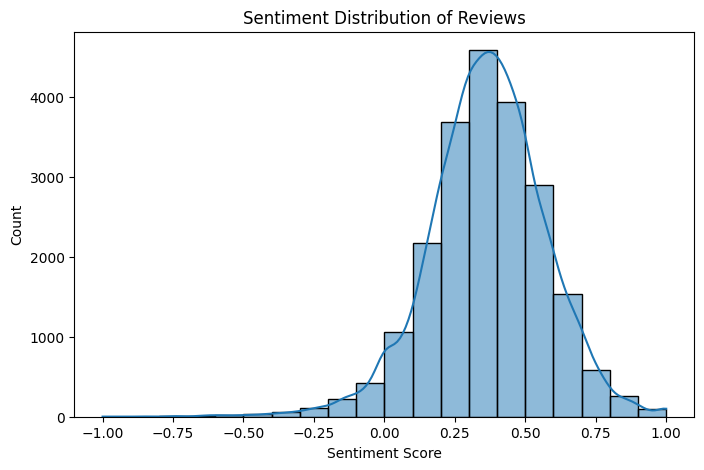

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob
import nltk

# Sentiment Analysis
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df_reviews["sentiment"] = df_reviews["clean_review"].apply(get_sentiment)

plt.figure(figsize=(8, 5))
sns.histplot(df_reviews["sentiment"], bins=20, kde=True)
plt.title("Sentiment Distribution of Reviews")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

////////// TODO: update this. /////////
**Interpretation**:

1.   The highest peak around 0 suggests many neutral reviews.

2.   The right-skewed part (higher counts at positive values) indicates more positive reviews than negative ones.

3. Some reviews are strongly positive (close to 1), while a few are negative (close to -1).

Overall, the restaurant reviews are mostly neutral to positive, with fewer negative reviews.

#### 2. Most Common Words

In [11]:
## TODO: can we do better?? maybe refer to prof's exercises?
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_most_common_words(texts, n=20):
    words = " ".join(texts).lower().split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return Counter(words).most_common(n)

common_words = get_most_common_words(df_reviews["review_text_en"].dropna())
print("Most common words:", common_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most common words: [('good', 12649), ('food', 8343), ('restaurant', 7193), ('service', 6498), ('really', 5074), ('place', 4270), ('excellent', 3863), ('staff', 3833), ('dishes', 3662), ('recommend', 3555), ('well', 3043), ('little', 3027), ('hotel', 2774), ('berlin', 2750), ('atmosphere', 2696), ('nice', 2582), ('also', 2316), ('best', 2287), ('pleasant', 2285), ('german', 2225)]


3. Identify Top Keywords / Themes

In [12]:
# Check top 20 most frequent words (from TF-IDF)
tfidf_df.mean().sort_values(ascending=False).head(20)

,0
good,0.067040
food,0.048172
restaurant,0.047161
service,0.043565
dish,0.035133
excellent,0.035078
place,0.033554
berlin,0.033108
really,0.030458
staff,0.029518


#### 3. Word Cloud

3.1. Side-by-Side Word Clouds for Positive & Negative Reviews (Global Overview)

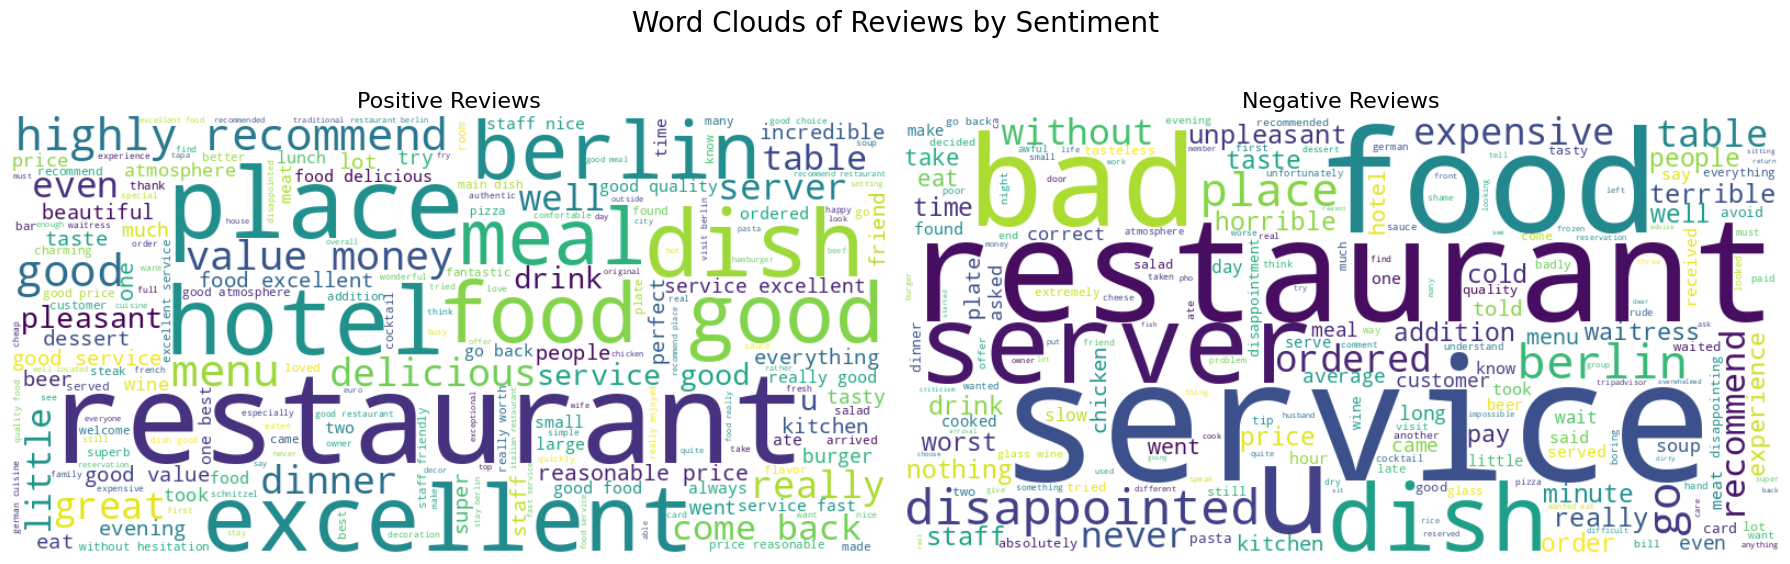

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob

# Step 1: Sentiment Scoring
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df_reviews["sentiment"] = df_reviews["clean_review"].apply(get_sentiment)

# Step 2: Categorize Sentiment
def categorize_sentiment(score):
    if score > 0.2:
        return "Positive"
    elif score < -0.2:
        return "Negative"
    else:
        return "Neutral"

df_reviews["sentiment_category"] = df_reviews["sentiment"].apply(categorize_sentiment)

# Step 3: Word Clouds - Side by Side

# Positive review text
text_pos = " ".join(df_reviews[df_reviews["sentiment_category"] == "Positive"]["clean_review"].dropna())

# Negative review text
text_neg = " ".join(df_reviews[df_reviews["sentiment_category"] == "Negative"]["clean_review"].dropna())

# Generate word clouds
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(text_pos)
wordcloud_neg = WordCloud(width=800, height=400, background_color="white").generate(text_neg)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("Word Clouds of Reviews by Sentiment", fontsize=20)

# Positive Reviews
axs[0].imshow(wordcloud_pos, interpolation="bilinear")
axs[0].set_title("Positive Reviews", fontsize=16)
axs[0].axis("off")

# Negative Reviews
axs[1].imshow(wordcloud_neg, interpolation="bilinear")
axs[1].set_title("Negative Reviews", fontsize=16)
axs[1].axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


3.2.Remove or exclude specific words from the WordCloud to make it more interpretable.

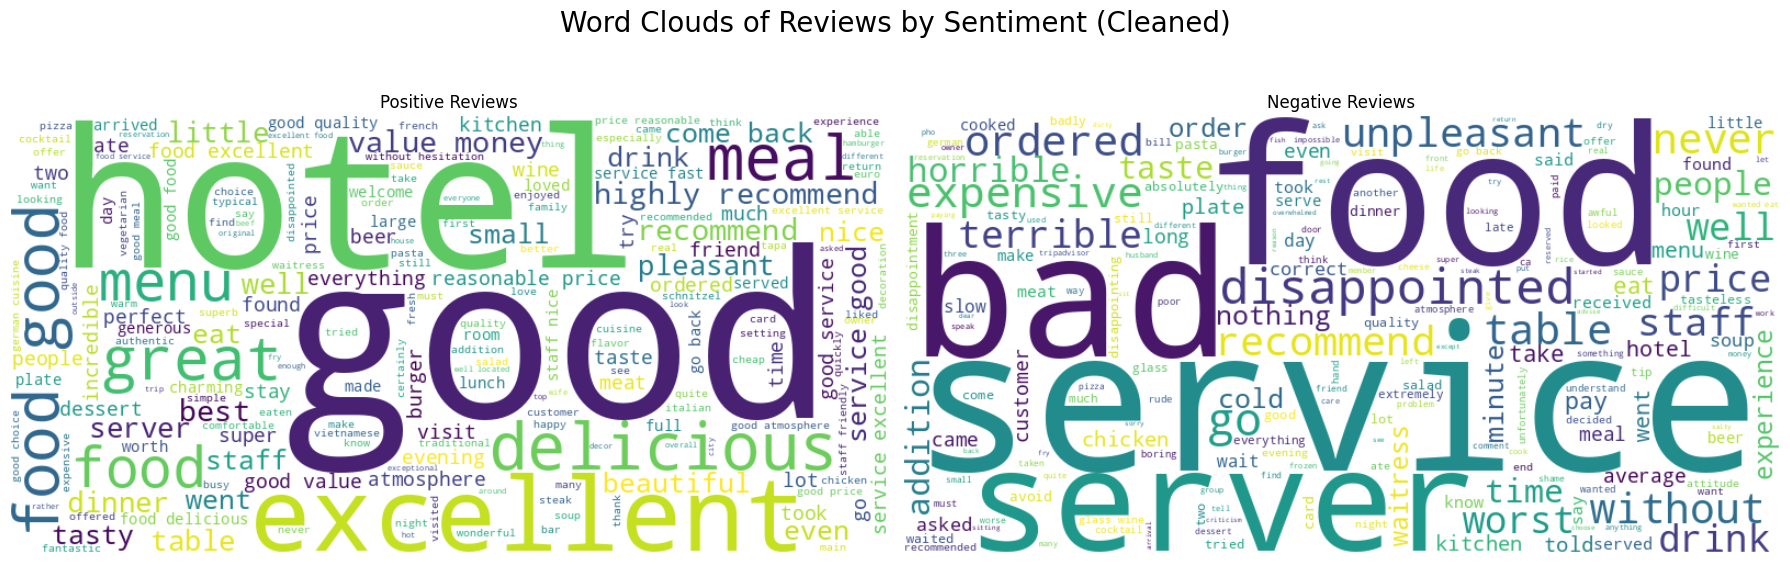

In [14]:
from wordcloud import WordCloud, STOPWORDS

# Define custom stopwords (you can add more)
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "restaurant", "berlin", "one","really","u","place","really", "always","dish" # 👈 add your unwanted words

])

# Create WordCloud for POSITIVE
text_pos = " ".join(df_reviews[df_reviews["sentiment_category"] == "Positive"]["clean_review"].dropna())
wordcloud_pos = WordCloud(width=800, height=400, background_color="white", stopwords=custom_stopwords).generate(text_pos)

# Create WordCloud for NEGATIVE
text_neg = " ".join(df_reviews[df_reviews["sentiment_category"] == "Negative"]["clean_review"].dropna())
wordcloud_neg = WordCloud(width=800, height=400, background_color="white", stopwords=custom_stopwords).generate(text_neg)

# Plot side-by-side
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("Word Clouds of Reviews by Sentiment (Cleaned)", fontsize=20)

axs[0].imshow(wordcloud_pos, interpolation="bilinear")
axs[0].set_title("Positive Reviews")
axs[0].axis("off")

axs[1].imshow(wordcloud_neg, interpolation="bilinear")
axs[1].set_title("Negative Reviews")
axs[1].axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

3.3 The word "hotel" appears frequently in wordclouds, it likely means it's a common word mentioned in many reviews — perhaps users are referring to “hotel restaurants”, locations, or comparing hotel food/service. We will investigate to find the reasons.

In [15]:
#Check how often "hotel" appears in reviews
df_reviews["contains_hotel"] = df_reviews["clean_review"].str.contains(r"\bhotel\b", case=False, na=False)
df_reviews["contains_hotel"].value_counts()

,count
contains_hotel,
False,18397
True,3272


In [16]:
#See example reviews that contain the word "hotel"
df_reviews[df_reviews["contains_hotel"]][["review_text_en", "clean_review", "sentiment_category"]].head(10)

,review_text_en,clean_review,sentiment_category
32,Superb food and good value for money. Extremel...,superb food good value money extremely busy re...,Positive
50,"Small restaurant right next to the hotel, very...",small restaurant right next hotel discreet mea...,Positive
57,"2nd time in 2 days, our hotel being very close...",time day hotel close delicious pleasant cheap ...,Positive
62,A practical restaurant near our hotel. We went...,practical restaurant near hotel went first eve...,Positive
76,Excellent Vietnamese cuisine without tralala. ...,excellent vietnamese cuisine without tralala c...,Neutral
77,We were looking for a restaurant close to our ...,looking restaurant close hotel adina apartment...,Neutral
91,Very well located: close to the Hotel Le Titan...,well located close hotel le titanic chaussee h...,Positive
92,Small Vietnamese restaurant near our hotel. I ...,small vietnamese restaurant near hotel found a...,Neutral
93,"A nice restaurant, close to the I31 hotel and ...",nice restaurant close hotel really expensive p...,Neutral
95,We stayed 4 nights at the i31 hotel next door ...,stayed night hotel next door easy move good ch...,Positive


In [17]:
#Check percentage of reviews that mention 'hotel' per cuisin
# Total number of reviews per cuisine
total_reviews_by_cuisine = df_reviews["cuisine"].value_counts()

# Number of reviews containing 'hotel' per cuisine
hotel_freq_by_cuisine = df_reviews[df_reviews["contains_hotel"]]["cuisine"].value_counts()

# Percentage of reviews that mention 'hotel'
hotel_percentage = (hotel_freq_by_cuisine / total_reviews_by_cuisine * 100).round(2)

# Combine into a summary DataFrame
hotel_summary = pd.DataFrame({
    "Total Reviews": total_reviews_by_cuisine,
    "Reviews with 'hotel'": hotel_freq_by_cuisine,
    "Percentage(%)": hotel_percentage
}).fillna(0).astype({"Reviews with 'hotel'": int, "Total Reviews": int})

# Display sorted by percentage
hotel_summary = hotel_summary.sort_values(by="Percentage(%)", ascending=False)

display(hotel_summary)

,Total Reviews,Reviews with 'hotel',Percentage(%)
cuisine,,,
italian,1494,249,16.67
pizza,1204,196,16.28
spanish,162,26,16.05
american,1651,261,15.81
french,1485,231,15.56
chinese,2740,425,15.51
vietnamese,2740,425,15.51
german,6150,939,15.27
mexican,621,94,15.14


In [18]:
#Step 4: Look at sentiment breakdown of "hotel" mentions
hotel_sentiment = df_reviews[df_reviews["contains_hotel"]]["sentiment_category"].value_counts()
print(hotel_sentiment)

sentiment_category
Positive    2720
Neutral      534
Negative      18
Name: count, dtype: int64


2. Side-by-Side Word Clouds for Positive & Negative Reviews by Cuisine

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "restaurant", "berlin", "one","really","u","place","really", "always","dish","good","food" # add your unwanted words

])

# Sentiment Scoring
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df_reviews["sentiment"] = df_reviews["clean_review"].apply(get_sentiment)

# Sentiment Categorization
def categorize_sentiment(score):
    if score > 0.2:
        return "Positive"
    elif score < -0.2:
        return "Negative"
    else:
        return "Neutral"

df_reviews["sentiment_category"] = df_reviews["sentiment"].apply(categorize_sentiment)

# Loop through each cuisine to generate side-by-side word clouds
unique_cuisines = df_reviews["cuisine"].unique()

for cuisine in unique_cuisines:
    cuisine_df = df_reviews[df_reviews["cuisine"] == cuisine]

    text_pos = " ".join(cuisine_df[cuisine_df["sentiment_category"] == "Positive"]["clean_review"].dropna())
    text_neg = " ".join(cuisine_df[cuisine_df["sentiment_category"] == "Negative"]["clean_review"].dropna())

    if not text_pos.strip() and not text_neg.strip():
        print(f" Skipping {cuisine.title()} cuisine - no reviews.")
        continue

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Word Clouds - {cuisine.title()} Cuisine", fontsize=18)

    # Positive Word Cloud
    if text_pos.strip():
        wordcloud_pos = WordCloud(width=800, height=400, background_color="white", stopwords=custom_stopwords).generate(text_pos)
        axs[0].imshow(wordcloud_pos, interpolation="bilinear")
        axs[0].set_title("Positive Reviews", fontsize=14)
    else:
        axs[0].text(0.5, 0.5, "No Positive Reviews", ha='center', va='center', fontsize=12)
    axs[0].axis("off")

    # Negative Word Cloud
    if text_neg.strip():
        wordcloud_neg = WordCloud(width=800, height=400, background_color="white", stopwords=custom_stopwords).generate(text_neg)
        axs[1].imshow(wordcloud_neg, interpolation="bilinear")
        axs[1].set_title("Negative Reviews", fontsize=14)
    else:
        axs[1].text(0.5, 0.5, "No Negative Reviews", ha='center', va='center', fontsize=12)
    axs[1].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### 4. Rating Trends Over Time

Could not parse: R√©dig√© le 31 d√©cembre 2018
Could not parse: R√©dig√© le 30 d√©cembre 2018
Could not parse: R√©dig√© le 17 ao√ªt 2018
Could not parse: R√©dig√© le 19 f√©vrier 2025
Could not parse: R√©dig√© le 21 d√©cembre 2024
Could not parse: R√©dig√© le 15 f√©vrier 2020
Could not parse: R√©dig√© le 14 f√©vrier 2020
Could not parse: R√©dig√© le 31 d√©cembre 2017
Could not parse: R√©dig√© le 15 ao√ªt 2024
Could not parse: R√©dig√© le 21 f√©vrier 2024
Could not parse: R√©dig√© le 31 ao√ªt 2022
Could not parse: R√©dig√© le 14 f√©vrier 2022
Could not parse: R√©dig√© le 29 ao√ªt 2019
Could not parse: R√©dig√© le 23 ao√ªt 2017
Could not parse: R√©dig√© le 20 ao√ªt 2017
Could not parse: R√©dig√© le 18 ao√ªt 2017
Could not parse: R√©dig√© le 28 d√©cembre 2024
Could not parse: R√©dig√© le 25 d√©cembre 2024
Could not parse: R√©dig√© le 21 ao√ªt 2024
Could not parse: R√©dig√© le 21 ao√ªt 2024
Could not parse: R√©dig√© le 18 ao√ªt 2024
Could not parse: R√©dig√© le 16 ao√ªt 2018
Could not parse

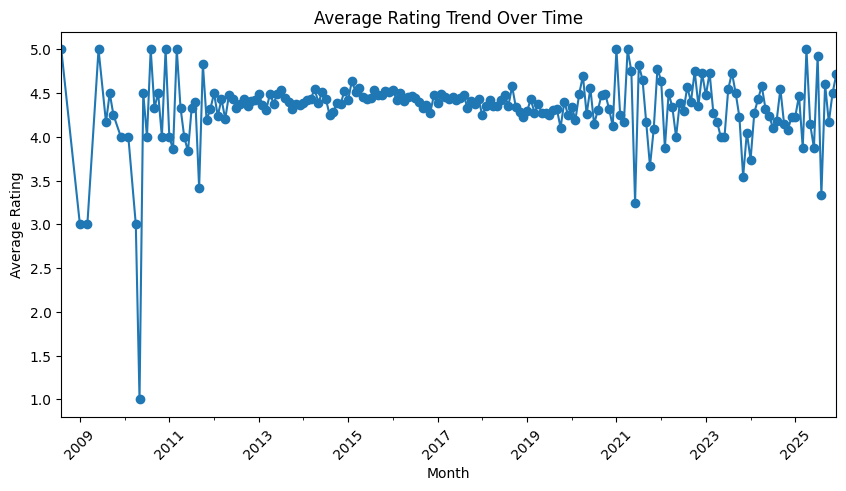

In [ ]:
## TODO: This is ideally working. but what can we improve here??
from dateutil import parser

def parse_french_date(date_str):
    try:
        # First attempt: standard parsing with fuzzy matching
        return parser.parse(date_str, dayfirst=False, fuzzy=True)
    except ValueError:
        try:
            # Second attempt: replace French month names with English equivalents
            french_to_english_months = {
                "janvier": "january",
                "février": "february",
                "mars": "march",
                "avril": "april",
                "mai": "may",
                "juin": "june",
                "juillet": "july",
                "août": "august",
                "septembre": "september",
                "octobre": "october",
                "novembre": "november",
                "décembre": "december",
                # Add variations/abbreviations if needed (e.g., "avr": "april")
            }

            for french_month, english_month in french_to_english_months.items():
                date_str = date_str.replace(french_month, english_month)

            return parser.parse(date_str, dayfirst=False, fuzzy=True)
        except ValueError:
            print(f"Could not parse: {date_str}")
            return pd.NaT

df_reviews["date"] = df_reviews["review_date"].apply(parse_french_date)
rating_trend = df_reviews.groupby(df_reviews["date"].dt.to_period("M"))["rating"].mean()

plt.figure(figsize=(10, 5))
rating_trend.plot(marker="o")
plt.title("Average Rating Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

#### 5. Common Complaints and Praises

In [ ]:
## TODO: let's do better
def categorize_sentiment(score):
    if score > 0.2:
        return "Positive"
    elif score < -0.2:
        return "Negative"
    else:
        return "Neutral"

df_reviews["sentiment_category"] = df_reviews["sentiment"].apply(categorize_sentiment)

common_complaints = get_most_common_words(df_reviews[df_reviews["sentiment_category"] == "Negative"]["clean_review"].dropna())
common_praises = get_most_common_words(df_reviews[df_reviews["sentiment_category"] == "Positive"]["clean_review"].dropna())

print("Common Complaints:", common_complaints)
print("Common Praises:", common_praises)

Common Complaints: [('service', 98), ('restaurant', 95), ('food', 90), ('bad', 75), ('server', 53), ('dish', 52), ('disappointed', 44), ('berlin', 40), ('place', 38), ('unpleasant', 34), ('expensive', 34), ('ordered', 33), ('table', 33), ('never', 32), ('without', 32), ('recommend', 31), ('staff', 30), ('worst', 30), ('really', 29), ('terrible', 28)]
Common Praises: [('good', 14508), ('restaurant', 8867), ('food', 8724), ('service', 7429), ('excellent', 5373), ('berlin', 5289), ('dish', 5231), ('place', 5020), ('really', 4298), ('staff', 4031), ('price', 3903), ('delicious', 3874), ('atmosphere', 3798), ('recommend', 3465), ('hotel', 3413), ('nice', 3190), ('great', 3037), ('well', 2969), ('pleasant', 2953), ('meal', 2767)]


#### 6. Seasonal Trends

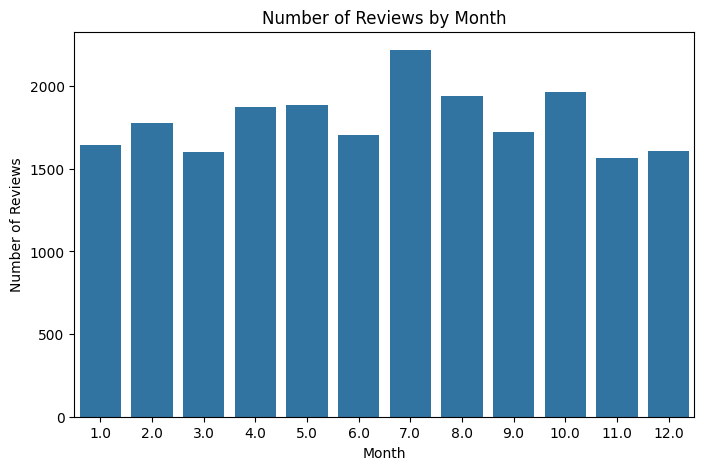

In [ ]:
df_reviews["month"] = df_reviews["date"].dt.month
monthly_reviews = df_reviews.groupby("month")["rating"].count()

plt.figure(figsize=(8, 5))
sns.barplot(x=monthly_reviews.index, y=monthly_reviews.values)
plt.title("Number of Reviews by Month")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.show()


#### 7. N-gram

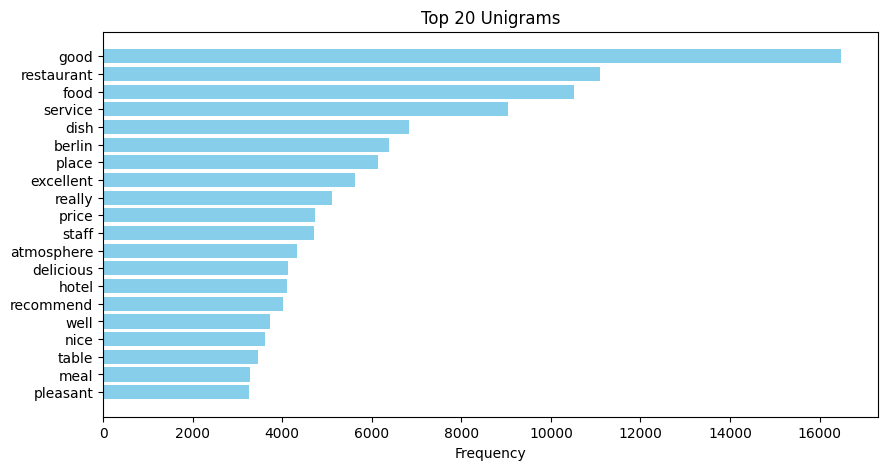

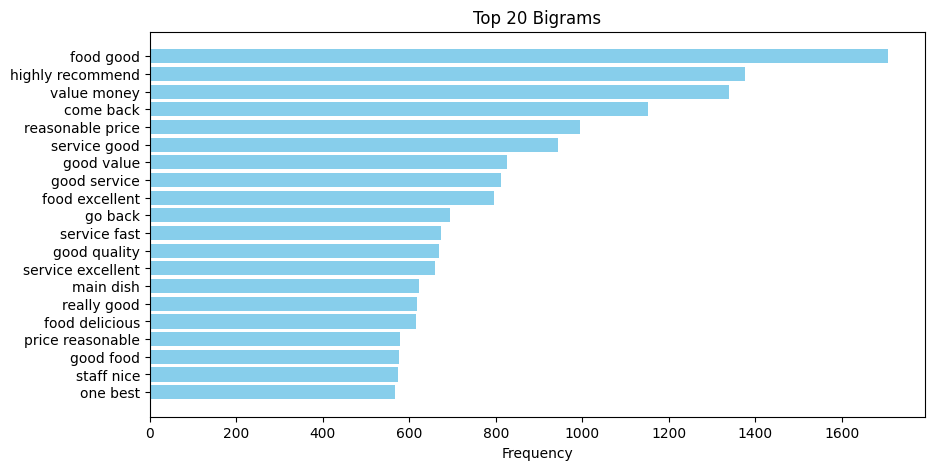

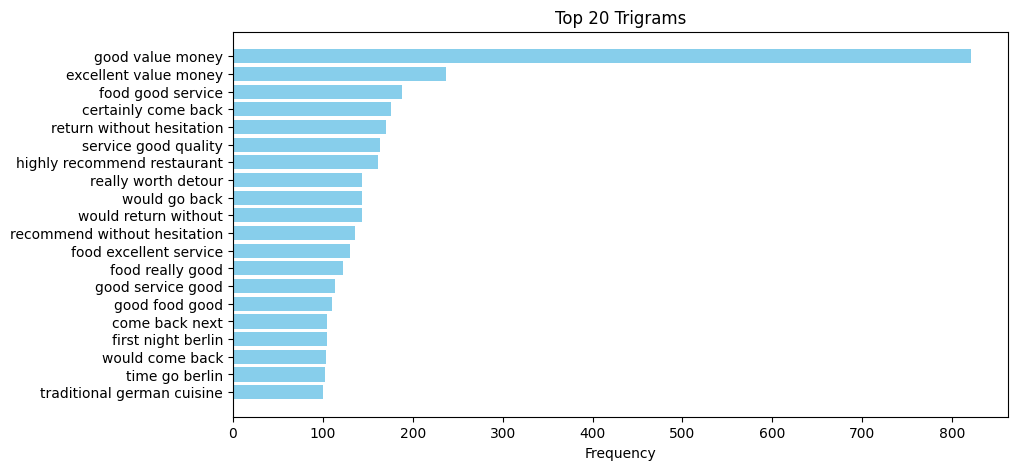

Top Unigrams: [('good', 16483), ('restaurant', 11101), ('food', 10508), ('service', 9045), ('dish', 6840), ('berlin', 6387), ('place', 6135), ('excellent', 5636), ('really', 5121), ('price', 4724), ('staff', 4718), ('atmosphere', 4336), ('delicious', 4120), ('hotel', 4106), ('recommend', 4013), ('well', 3723), ('nice', 3610), ('table', 3470), ('meal', 3290), ('pleasant', 3264)]
Top Bigrams: [('food good', 1706), ('highly recommend', 1375), ('value money', 1340), ('come back', 1152), ('reasonable price', 994), ('service good', 944), ('good value', 825), ('good service', 811), ('food excellent', 795), ('go back', 695), ('service fast', 673), ('good quality', 668), ('service excellent', 659), ('main dish', 623), ('really good', 617), ('food delicious', 615), ('price reasonable', 579), ('good food', 577), ('staff nice', 574), ('one best', 567)]
Top Trigrams: [('good value money', 821), ('excellent value money', 237), ('food good service', 188), ('certainly come back', 176), ('return withou

In [ ]:
# N-gram Extraction Function
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_ngrams(texts, n=2, top_n=20):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(texts)
    ngram_counts = X.toarray().sum(axis=0)
    ngram_freq = dict(zip(vectorizer.get_feature_names_out(), ngram_counts))
    return Counter(ngram_freq).most_common(top_n)

# Get Unigrams, Bigrams, and Trigrams
unigrams = get_ngrams(df_reviews["clean_review"], n=1)
bigrams = get_ngrams(df_reviews["clean_review"], n=2)
trigrams = get_ngrams(df_reviews["clean_review"], n=3)

# Plot function
def plot_ngrams(ngrams, title):
    ngrams_dict = dict(ngrams)
    plt.figure(figsize=(10, 5))
    plt.barh(list(ngrams_dict.keys()), list(ngrams_dict.values()), color="skyblue")
    plt.xlabel("Frequency")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Plot top N-grams
plot_ngrams(unigrams, "Top 20 Unigrams")
plot_ngrams(bigrams, "Top 20 Bigrams")
plot_ngrams(trigrams, "Top 20 Trigrams")

# Print top N-grams
print("Top Unigrams:", unigrams)
print("Top Bigrams:", bigrams)
print("Top Trigrams:", trigrams)

8.Analyzing Review Patterns by Visitor Type and Cuisine Using TF-IDF and Sentiment Analysis

In [20]:
df_reviews["type_visit"].value_counts()

,count
type_visit,
couples,7785
friends,4790
family,3509
none,2758
business,1029
solo,883


In [21]:
import pandas as pd

# Get the minimum group size
min_count = df_reviews['type_visit'].value_counts().min()

# Downsample each group
balanced_df = (
    df_reviews
    .groupby('type_visit', group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
    .reset_index(drop=True)
)

# Check the result
print(balanced_df['type_visit'].value_counts())

type_visit
business    883
couples     883
family      883
friends     883
none        883
solo        883
Name: count, dtype: int64


<ipython-input-21-2e5ee04748d8>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


In [22]:
pd.crosstab(balanced_df["type_visit"], balanced_df["sentiment_category"], normalize='index') * 100

sentiment_category,Negative,Neutral,Positive
type_visit,,,
business,1.585504,18.120045,80.294451
couples,0.339751,17.440544,82.219706
family,0.792752,18.686297,80.520951
friends,0.906002,17.667044,81.426954
none,1.019253,20.045300,78.935447
solo,0.792752,20.611552,78.595696


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
# Define custom stopwords (you can expand this list)
custom_stopwords = [
    "berlin", "choice", "cuisine", "dish", "eat", "food", "meal", "place", "really"
]

# Grouped keywords dictionary
tfidf_keywords_per_type = {}

# Loop through each type of visit
for visit in balanced_df["type_visit"].dropna().unique():
    # Filter clean text for the current visit type
    texts = balanced_df[balanced_df["type_visit"] == visit]["clean_review"].dropna()

    if texts.empty:
        continue  # Skip empty groups

    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=30, stop_words='english')  # adjust max_features as needed
    tfidf_matrix = vectorizer.fit_transform(texts)



    # Get top terms
    tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Convert matrix to array
    feature_names = vectorizer.get_feature_names_out()

    tfidf_scores_dict = dict(zip(feature_names, tfidf_scores))

    # Sort by score
    # Remove custom stopwords from tfidf result
    filtered_scores_dict = {k: v for k, v in tfidf_scores_dict.items() if k not in custom_stopwords}

    # Sort after filtering
    sorted_keywords = sorted(tfidf_scores_dict.items(), key=lambda x: x[1], reverse=True)

    tfidf_keywords_per_type[visit] = sorted_keywords


# Convert TF-IDF keyword dict into a DataFrame
df_tfidf_keywords = pd.DataFrame()

for visit_type, keyword_scores in tfidf_keywords_per_type.items():
    temp_df = pd.DataFrame(keyword_scores, columns=["Keyword", visit_type])
    temp_df.set_index("Keyword", inplace=True)

    if df_tfidf_keywords.empty:
        df_tfidf_keywords = temp_df
    else:
        df_tfidf_keywords = df_tfidf_keywords.join(temp_df, how="outer")

# Replace missing values with 0 (if a word does not appear in one visit type)
df_tfidf_keywords.fillna(0, inplace=True)

# Round for readability
df_tfidf_keywords = df_tfidf_keywords.round(0).astype(int)

# Display the table
from IPython.display import display
display(df_tfidf_keywords.style.set_caption("TF-IDF Keywords Across Visit Types")
       .format(na_rep="-")
       .highlight_max(axis=1, props='background-color: #ffeb3b; font-weight: bold;'))

,business,couples,family,friends,none,solo
Keyword,,,,,,
atmosphere,60,72,59,69,62,52
beer,0,0,0,0,0,43
berlin,81,80,75,82,73,86
best,40,0,0,52,43,45
choice,48,0,0,38,0,0
cuisine,0,0,44,0,46,0
delicious,52,65,65,59,63,60
dinner,48,41,0,0,0,0
dish,85,90,101,91,77,83


## 6. Unsupervised Learning

### Approach 1. Topic Modeling with Latent Dirichlet Allocation (LDA)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords  # Ensure stopwords is imported

# Get the English stop words as a list
stop_words_list = stopwords.words('english')

# Vectorization
count_para_vectorizer = CountVectorizer(stop_words=stop_words_list, min_df=5, max_df=0.9)
count_para_vectors = count_para_vectorizer.fit_transform(df_reviews["clean_review"])
count_para_vectors.shape

(21669, 4805)

In [25]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42, n_jobs=-1)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

CPU times: user 2.17 s, sys: 335 ms, total: 2.5 s
Wall time: 1min 53s


In [ ]:
W_lda_para_matrix.shape, H_lda_para_matrix.shape

((21669, 10), (10, 4805))

In [ ]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [ ]:
display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())


Topic 00
  good (4.54)
  restaurant (3.13)
  dish (2.87)
  nice (2.38)
  service (2.07)

Topic 01
  food (2.71)
  good (1.89)
  indian (1.56)
  restaurant (1.52)
  really (1.25)

Topic 02
  table (2.96)
  restaurant (2.00)
  evening (1.92)
  food (1.65)
  reservation (1.39)

Topic 03
  restaurant (3.60)
  good (3.43)
  food (2.04)
  place (1.56)
  service (1.38)

Topic 04
  dish (4.76)
  good (2.31)
  delicious (1.94)
  chicken (1.47)
  fresh (1.44)

Topic 05
  berlin (2.40)
  food (2.34)
  best (1.98)
  place (1.98)
  really (1.95)

Topic 06
  restaurant (2.48)
  berlin (2.10)
  food (2.08)
  good (1.67)
  english (1.34)

Topic 07
  good (3.36)
  wine (2.51)
  dish (1.58)
  restaurant (1.23)
  dessert (1.16)

Topic 08
  good (7.14)
  food (4.75)
  service (3.81)
  excellent (2.49)
  place (2.14)

Topic 09
  restaurant (1.31)
  dish (1.13)
  server (1.06)
  service (1.03)
  little (0.83)


### LDA Visualization

In [ ]:
try:
  import pyLDAvis.sklearn
except:
  !pip install pyLDAvis # Install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
"""
pyLDAvis sklearn
===============
Helper functions to visualize sklearn's LatentDirichletAllocation models
"""
import funcy as fp
import pyLDAvis


def _get_doc_lengths(dtm):
    return dtm.sum(axis=1).getA1()


def _get_term_freqs(dtm):
    return dtm.sum(axis=0).getA1()


def _get_vocab(vectorizer):
    return vectorizer.get_feature_names_out()


def _row_norm(dists):
    # row normalization function required
    # for doc_topic_dists and topic_term_dists
    return dists / dists.sum(axis=1)[:, None]


def _get_doc_topic_dists(lda_model, dtm):
    return _row_norm(lda_model.transform(dtm))


def _get_topic_term_dists(lda_model):
    return _row_norm(lda_model.components_)


def _extract_data(lda_model, dtm, vectorizer):
    vocab = _get_vocab(vectorizer)
    doc_lengths = _get_doc_lengths(dtm)
    term_freqs = _get_term_freqs(dtm)
    topic_term_dists = _get_topic_term_dists(lda_model)
    err_msg = ('Topic-term distributions and document-term matrix'
               'have different number of columns, {} != {}.')

    assert term_freqs.shape[0] == len(vocab), \
        ('Term frequencies and vocabulary are of different sizes, {} != {}.'
         .format(term_freqs.shape[0], len(vocab)))

    assert topic_term_dists.shape[1] == dtm.shape[1], \
        (err_msg.format(topic_term_dists.shape[1], len(vocab)))

    # column dimensions of document-term matrix and topic-term distributions
    # must match first before transforming to document-topic distributions
    doc_topic_dists = _get_doc_topic_dists(lda_model, dtm)
    return {'vocab': vocab,
            'doc_lengths': doc_lengths.tolist(),
            'term_frequency': term_freqs.tolist(),
            'doc_topic_dists': doc_topic_dists.tolist(),
            'topic_term_dists': topic_term_dists.tolist()}


def prepare(lda_model, dtm, vectorizer, **kwargs):
    opts = fp.merge(_extract_data(lda_model, dtm, vectorizer), kwargs)
    return pyLDAvis.prepare(**opts)


### LDA Visualization with TSNE
- To understand the main topics people are talking about, this code takes the results of that analysis (lda_para_model, count_para_vectors, count_para_vectorizer) and prepares them in a way that can be easily visualized using the pyLDAvis library.
- t-SNE (t-distributed Stochastic Neighbor Embedding) helps to produce more distinct and interpretable clusters of topics.

In [ ]:
lda_tsne_display = prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False, mds='tsne')
pyLDAvis.display(lda_tsne_display)

### Wordcloud from LDA model

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

In [ ]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# //// TODO: to be improved. /////

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to assign topic labels dynamically
def assign_topic_labels(lda_model, vectorizer, num_words=10):
    words = vectorizer.get_feature_names_out()
    topic_labels = {}

    # Expanded keyword categories
    categories = {
        "Food & Menu": ["food", "dish", "meal", "menu", "delicious", "flavor", "taste", "cuisine", "chef", "spices"],
        "Customer Service": ["service", "staff", "waiter", "friendly", "rude", "helpful", "unprofessional", "slow", "fast", "polite"],
        "Pricing & Cost": ["price", "expensive", "cheap", "value", "affordable", "overpriced", "reasonable", "worth", "budget", "cost"],
        "Ambience & Experience": ["atmosphere", "cozy", "decor", "music", "lighting", "view", "seating", "romantic", "noisy", "comfortable"],
        "Cleanliness & Hygiene": ["clean", "dirty", "hygiene", "sanitary", "smell", "spotless", "filthy", "messy", "fresh", "neat"],
        "Portion Size": ["portion", "small", "big", "large", "tiny", "quantity", "generous", "filling", "satisfying", "huge"],
        "Waiting Time": ["wait", "long", "slow", "fast", "quick", "minutes", "hours", "delay", "time", "efficient"],
        "General Sentiment": ["recommend", "amazing", "terrible", "excellent", "horrible", "fantastic", "bad", "great", "awful", "favorite"]
    }

    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [words[i] for i in topic.argsort()[:-num_words - 1:-1]]

        # Assign a label based on the most frequent category match
        assigned_label = "General Reviews"  # Default label
        max_matches = 0

        for category, keywords in categories.items():
            matches = sum(1 for word in top_words if word in keywords)
            if matches > max_matches:
                max_matches = matches
                assigned_label = category

        topic_labels[f"Topic {topic_idx+1}"] = {"label": assigned_label, "top_words": top_words}

    return topic_labels

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df_reviews['clean_review'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

topic_labels = assign_topic_labels(lda, vectorizer)

# Print assigned labels
for topic, info in topic_labels.items():
    print(f"{topic}: {info['label']} - {info['top_words']}")

# Extract complaints (negative reviews)
# complaints = df_reviews[df_reviews["sentiment"] < -0.2]["clean_review"]
# print("Common Complaints:", complaints.head(10))



Topic 1: Food & Menu - ['good', 'food', 'restaurant', 'dish', 'really', 'place', 'service', 'time', 'little', 'table']
Topic 2: Food & Menu - ['good', 'german', 'beer', 'restaurant', 'dish', 'english', 'large', 'place', 'traditional', 'berlin']
Topic 3: Food & Menu - ['good', 'dish', 'restaurant', 'service', 'price', 'wine', 'excellent', 'quality', 'berlin', 'nice']
Topic 4: Customer Service - ['food', 'good', 'service', 'berlin', 'restaurant', 'excellent', 'place', 'staff', 'atmosphere', 'hotel']
Topic 5: Food & Menu - ['table', 'restaurant', 'good', 'burger', 'delicious', 'reservation', 'hotel', 'book', 'food', 'service']


<!-- K-Means groups reviews with similar word patterns into clusters. -->

### Approach 2: K-Means : groups reviews with similar word patterns into clusters.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df_reviews['clean_review'])

# Fit K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

# Add cluster labels to dataframe
df_reviews['Cluster'] = labels

# Display top words per cluster
import numpy as np

words = np.array(vectorizer.get_feature_names_out())
for cluster in range(5):
    top_words = words[np.argsort(kmeans.cluster_centers_[cluster])[-10:]]
    print(f"Cluster {cluster}: {top_words}")

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x794ce539f740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/scipy.libs/libscipy_openblas-c128ec02.

Cluster 0: ['berlin' 'server' 'nice' 'table' 'excellent' 'little' 'service' 'good'
 'restaurant' 'dish']
Cluster 1: ['place' 'berlin' 'dish' 'restaurant' 'food' 'service' 'excellent' 'good'
 'money' 'value']
Cluster 2: ['staff' 'nice' 'pleasant' 'quality' 'place' 'atmosphere' 'restaurant'
 'service' 'food' 'good']
Cluster 3: ['recommend' 'staff' 'dish' 'excellent' 'service' 'restaurant' 'food'
 'good' 'reasonable' 'price']
Cluster 4: ['delicious' 'staff' 'excellent' 'great' 'hotel' 'restaurant' 'really'
 'place' 'berlin' 'food']


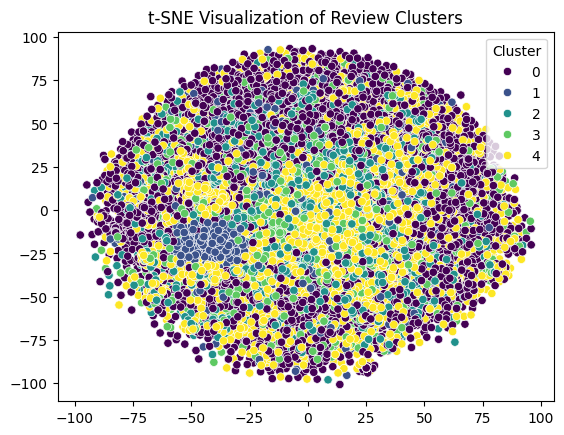

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(df_reviews['clean_review']).toarray()

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Scatter plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=df_reviews['Cluster'], palette='viridis')
plt.title("t-SNE Visualization of Review Clusters")
plt.show()

## 7. Supervised Learning

### 1. Sentiment classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define sentiment labels (adjust if needed)
df_reviews["sentiment_label"] = df_reviews["sentiment"].apply(lambda x: 1 if x > 0 else (0 if x == 0 else -1))

# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 words
X_text = vectorizer.fit_transform(df_reviews["clean_review"])

# Combine text features with other structured features (if available)
X = X_text.toarray()
y = df_reviews["sentiment_label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title(f"Confusion Matrix : {name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        10
           1       0.98      1.00      0.99       400

    accuracy                           0.98       410
   macro avg       0.49      0.50      0.49       410
weighted avg       0.95      0.98      0.96       410



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/usr/local/lib/python3.11/dist-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/usr/local/lib/python3.11/dist-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/usr/local/lib/python3.11/dist-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated.

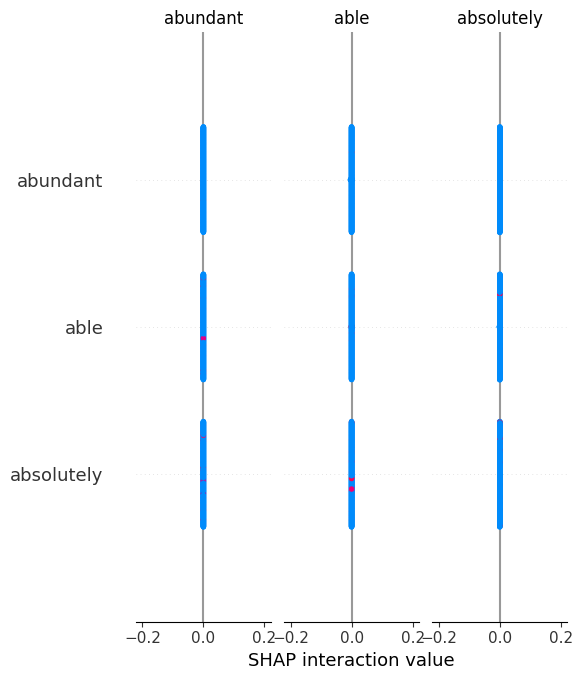

In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names_out())

In [26]:
df_reviews.columns

Index(['restaurant_url', 'restaurant_name', 'review_date', 'review_title',
       'review_text', 'rating', 'type_visit', 'user', 'user_profile',
       'num_contributions', 'review_text_en', 'review_title_en', 'cuisine',
       'clean_review', 'sentiment', 'sentiment_category', 'contains_hotel'],
      dtype='object')

### Rating prediction based on reviews

RMSE: 0.6371263027210191
R² Score: 0.4966638705816211

Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.10      0.17       104
           2       0.32      0.22      0.26       100
           3       0.48      0.38      0.42       301
           4       0.52      0.59      0.55      1256
           5       0.80      0.80      0.80      2573

    accuracy                           0.68      4334
   macro avg       0.58      0.42      0.44      4334
weighted avg       0.68      0.68      0.68      4334



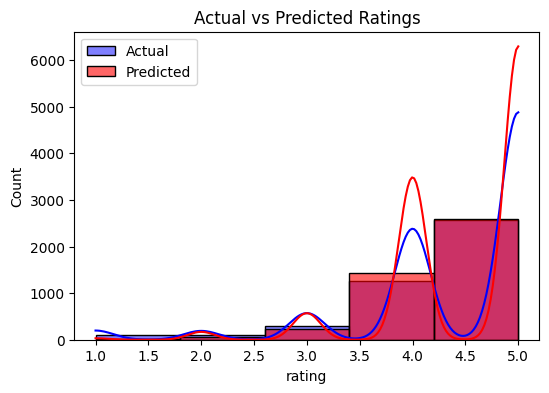

In [ ]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Step 1: Load Data (Assuming 'review_text' and 'rating' columns exist)
df_reviews_s = df_reviews[['review_text_en', 'rating']].dropna()  # Keep relevant columns and remove missing values

# Step 2: Preprocess Rating (Ensure it's numerical)
df_reviews_s['rating'] = df_reviews_s['rating'].astype(int)  # Ensure rating is an integer (1-5)

# Step 3: Split Data into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(df_reviews_s['review_text_en'], df_reviews_s['rating'], test_size=0.2, random_state=42)

# Step 4: Convert Text to Numerical Features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))  # Unigram & Bigram
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 5: Train a Machine Learning Model (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

# Step 6: Make Predictions
y_pred = model.predict(X_test_tfidf)

# Step 7: Evaluate Model Performance using Regression Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# Convert Predicted Ratings to Nearest Integer (Classification Task)
y_pred_class = np.round(y_pred).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))

# Step 8: Visualize Predictions
plt.figure(figsize=(6,4))
sns.histplot(y_test, color='blue', label="Actual", kde=True, bins=5)
sns.histplot(y_pred_class, color='red', label="Predicted", kde=True, bins=5, alpha=0.6)
plt.legend()
plt.title("Actual vs Predicted Ratings")
plt.show()

#### Interpretation:
1. Regression Metrics
- The model RMSE(Root Mean Squared Error) is 0.637. The lower RMSE is better.
- R2 value of 49.7% can be interpreted as there is room to improve in the performance.

2. Classification metrics
- Class 5 is predicted best 80% of precision and recall.
- Ratings such as 1, 2, 3 have low recall which means that the model rarely correctly identifies bad reviews.
- The overall accuracy is 68% representing high predictions from majority classes.

Next question:
- can we improve it by adding more features from our dataset?
Or by using better performing models?
Or can the ratings be balanced?


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE  # Handles class imbalance

# Step 1: Load Data
df_reviews_s = df_reviews[['review_text_en', 'rating', 'sentiment', 'type_visit', 'num_contributions', 'contains_hotel']].dropna()

# Step 2: Convert Categorical & Numerical Features
df_reviews_s['rating'] = df_reviews_s['rating'].astype(int)  # Ensure rating is an integer
df_reviews_s['contains_hotel'] = df_reviews_s['contains_hotel'].astype(int)  # Convert boolean to int
df_reviews_s['num_contributions'] = df_reviews_s['num_contributions'].fillna(0)  # Fill missing contributions with 0

# Encode 'type_visit' (categorical to numeric)
encoder = LabelEncoder()
df_reviews_s['type_visit'] = encoder.fit_transform(df_reviews_s['type_visit'])

# Step 3: Train-Test Split
X = df_reviews_s.drop(columns=['rating'])
y = df_reviews_s['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Process Text Data (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,3))
X_train_tfidf = vectorizer.fit_transform(X_train['review_text_en'])
X_test_tfidf = vectorizer.transform(X_test['review_text_en'])

# Step 5: Merge TF-IDF with Additional Features
X_train_final = np.hstack((X_train_tfidf.toarray(), X_train[['sentiment', 'type_visit', 'num_contributions', 'contains_hotel']].values))
X_test_final = np.hstack((X_test_tfidf.toarray(), X_test[['sentiment', 'type_visit', 'num_contributions', 'contains_hotel']].values))

# Step 6: Handle Class Imbalance (Optional)
# smote = SMOTE(random_state=42)
# X_train_final, y_train = smote.fit_resample(X_train_final, y_train)

# Step 7: Train a Machine Learning Model with Hyperparameter Tuning
rf = RandomForestRegressor()
param_dist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
search.fit(X_train_final, y_train)

# Step 8: Make Predictions
y_pred = search.best_estimator_.predict(X_test_final)

# Step 9: Evaluate Model Performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# Convert Predicted Ratings to Nearest Integer
y_pred_class = np.round(y_pred).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))

# Step 10: Visualize Actual vs Predicted Ratings
plt.figure(figsize=(6,4))
sns.histplot(y_test, color='blue', label="Actual", kde=True, bins=5)
sns.histplot(y_pred_class, color='red', label="Predicted", kde=True, bins=5, alpha=0.6)
plt.legend()
plt.title("Actual vs Predicted Ratings")
plt.show()